# Semantic Feature Extraction for Code Classification

This notebook extracts semantic features from code snippets which are later used for human vs. AI-generated code classification.

**Extracted features:**
- `verb_ratio_comments` — ratio of verbs in comment text (via spaCy POS tagging)
- `code_like_ratio` — fraction of lines classified as code by the text-vs-code model
- `comments_code_like_ratio_to_total` — code-like comment lines / total lines
- `comments_text_like_ratio_to_total` — text-like comment lines / total lines
- `comments_code_like_ratio_comments` — code-like comment lines / total comment lines
- `comments_text_like_ratio_comments` — text-like comment lines / total comment lines
- `completeness_score` — LLM-based estimate of whether the snippet is truncated

## Contents
1. Imports
2. Language Detection & NLP Setup
3. AST Parsing & Code Analysis Helpers
4. Feature Extraction Pipeline
5. Batch Processing & Dataset Construction
    - 5a. Balanced Sampling of Non-Python Snippets
    - 5b. Validation Set Feature Extraction
    - 5c. Export Processed Features
6. Feature Value Analysis
7. Feature Analysis by Label

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import re
from __future__ import annotations
from dataclasses import dataclass
from typing import List, Dict, Any, Optional

In [ ]:
import math
import numpy as np
from collections import Counter
from tree_sitter import Parser, Language

import tree_sitter_python
import tree_sitter_javascript
import tree_sitter_java
import tree_sitter_c_sharp
import tree_sitter_php
import tree_sitter_cpp
import tree_sitter_go


In [ ]:
from tree_sitter import Parser, Language
import tree_sitter_python
import tree_sitter_javascript
import tree_sitter_java
import tree_sitter_c_sharp
import tree_sitter_php
import tree_sitter_cpp
import tree_sitter_go

def get_language(module, lang_name):
    # PHP is special
    if lang_name == "php":
        return Language(module.language_php())
    else:
        return Language(module.language())

LANGUAGE_MODULES = {
    "python": tree_sitter_python,
    "javascript": tree_sitter_javascript,
    "java": tree_sitter_java,
    "c_sharp": tree_sitter_c_sharp,
    "php": tree_sitter_php,
    "cpp": tree_sitter_cpp,
    "go": tree_sitter_go,
}

def load_parsers():
    parsers = {}
    for lang, module in LANGUAGE_MODULES.items():
        parser = Parser()
        parser.language = get_language(module, lang)
        parsers[lang] = parser
    return parsers

parsers = load_parsers()
print("✔ Parsers loaded successfully")

## Language Detection & NLP Setup

Train a TF-IDF character n-gram classifier to detect the programming language, and load spaCy for comment linguistic analysis.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC


X = [
    # Python
    "def foo(): print('hi')",
    "def greet(name):\n return f\"hi {name}\"",
    "with open('a.txt','w') as f:\n f.write('hi')",
    "nums = [x*x for x in range(10) if x % 2 == 0]",
    "class Person:\n def __init__(self, name):\n self.name = name",

    # JavaScript
    "console.log('hi')",
    "const x = () => {}",
    "let n = 3;",
    "const add = (a, b) => a + b;",
    "console.log(fs.readFileSync('a.txt','utf8'))",
    "fetch('/api').then(r => r.json()).then(console.log)",

    # Java
   # Java (add these 6)
    "public static void main(String[] args){ System.out.println(\"hi\"); }",
    "public class B extends Thread { @Override public void run(){ System.out.println(getName()); } }",
    "public synchronized void inc(){ this.x++; }",
    "private static void f() throws Exception { throw new Exception(\"err\"); }",
    "import java.util.*;",
    "public class C { public static void main(String[] args){ System.out.println(Arrays.asList(1,2,3)); } }",


    # C
    "#include <stdio.h>\nprintf(\"hi\");",
    "#include <stdio.h>\nint main(void){ printf(\"hi\\n\"); return 0; }",
    "#include <stdlib.h>\nint *p = malloc(sizeof(int));",
    "struct Node { int x; struct Node* next; };",
    "#define MAX(a,b) ((a)>(b)?(a):(b))",
    "Node* n = getNode(); n->next = nullptr;",

    # C++
    "#include <iostream>\nstd::cout << \"hi\";",
    "std::vector<int> v;",
    "#include <iostream>\nint main(){ std::cout << \"hi\\n\"; }",
    "#include <vector>\nstd::vector<int> v{1,2,3};",
    "template<typename T> T add(T a, T b){ return a+b; }",
    "auto p = std::make_unique<int>(5);",

    # Go
    "package main\nfunc main() { fmt.Println(\"hi\") }",
    "x := 1",
    "package main\nimport \"fmt\"\nfunc main(){ fmt.Println(\"hi\") }",
    "x := 1\nif x > 0 { fmt.Println(x) }",
    "defer fmt.Println(\"bye\")",
    "ch := make(chan int)\ngo func(){ ch<-1 }()",

    # PHP
    "$user = getUser(); echo $user->name;",
    "$var = 5; echo $var;",
    "<?php $x = 5; echo $x; ?>",
    "<?php function foo($n){ return $n*2; } ?>",
    "<?php $arr = ['a'=>1,'b'=>2]; foreach($arr as $k=>$v){ echo $k; } ?>",
    "<?php class Person { public string $Name; } ?>",

    # C#  ⬅️ FIXED
    "using System;\nnamespace App { class Program { static void Main() { Console.WriteLine(\"hi\"); } } }",
    "public class Person { public string Name { get; set; } }",
    "class P { static void Main() { Console.WriteLine(\"hi\"); } }",
    "using System.Collections.Generic; var xs = new List<int>{1,2,3};",
    "[Serializable] public class A { public int X { get; set; } }",

]

y = [
    "python","python","python","python","python",
    "javascript","javascript","javascript","javascript","javascript","javascript",
    "java","java","java","java","java","java",
    "c","c","c","c","c","c",
    "c++","c++","c++","c++","c++","c++",
    "go","go","go","go","go","go",
    "php","php","php","php","php","php",
    "c#","c#","c#","c#","c#"
]


token_pat = r"[A-Za-z_]\w+|::|->|=>|:=|==|!=|<=|>=|\#include|<\w+\.h>|[{}()[\];,.\"]"

features = FeatureUnion([
    ("char", TfidfVectorizer(analyzer="char_wb", ngram_range=(3, 8), lowercase=False)),
    ("tok",  TfidfVectorizer(analyzer="word", token_pattern=token_pat, ngram_range=(1, 2), lowercase=False)),
])

clf_tf_idf = Pipeline([
    ("feat", features),
    ("model", LinearSVC()),
])

# C=0.1, loss='hinge'
clf_tf_idf.fit(X, y)

def detect(code):
    return clf_tf_idf.predict([code])[0]


In [ ]:
def _load_spacy(model: str = "en_core_web_sm"):
    import spacy
    try:
        return spacy.load(model)
    except OSError as e:
        raise RuntimeError(
            f"spaCy model '{model}' not found. Install it with:\n"
            f"  python -m spacy download {model}\n"
            f"Or pass a different model name."
        ) from e

In [ ]:
nlp = _load_spacy()

In [ ]:
LANGUAGE_MODULES = {
    "python": tree_sitter_python,
    "javascript": tree_sitter_javascript,
    "java": tree_sitter_java,
    "c_sharp": tree_sitter_c_sharp,
    "php": tree_sitter_php,
    "cpp": tree_sitter_cpp,
    "go": tree_sitter_go,
}


def get_language(module, name):
    # PHP is special
    if name == "php":
        return Language(module.language_php())
    return Language(module.language())


def load_parsers():
    parsers = {}
    for name, module in LANGUAGE_MODULES.items():
        parser = Parser()
        parser.language = get_language(module, name)   # ✅ NEW API
        parsers[name] = parser
    return parsers


## AST Parsing & Code Analysis Helpers

Helper functions for tree-sitter AST traversal, error node counting, comment extraction, identifier splitting, and linguistic feature computation.

In [ ]:
def walk(root):
    stack = [root]
    while stack:
        node = stack.pop()
        yield node
        stack.extend(node.children)

In [ ]:
def count_error_nodes(root):
    count = 0
    stack = [root]

    while stack:
        node = stack.pop()
        if node.type == "ERROR":
            count += 1
        stack.extend(node.children)

    return count

In [ ]:
def parse_best(code_str : str, parsers):
    code = code_str.encode("utf8")

    lang = detect(code_str)
    # print(lang)
    if lang == "c" or lang == "c++":
        lang = "cpp"
    elif lang == "c#":
        lang = "c_sharp"
    parser = parsers.get(lang, None)
    tree = parser.parse(code) if parser else None

    return lang, tree

In [ ]:
def is_statement(node):
    if node.type.endswith("_statement"):
        return True

    # Common cross-language fallbacks
    return node.type in {
        "expression_statement",
        "return_statement",
        "declaration",
        "assignment_expression",
        "variable_declaration",
        "local_declaration",
        "if_statement",
        "for_statement",
        "while_statement",
        "do_statement",
        "switch_statement",
        "throw_statement",
        "break_statement",
        "continue_statement",
    }

In [ ]:
def code_lines_no_comments(code: str, root):
    """
    Returns a list of code lines with all comment-only and comment-containing
    lines removed (Tree-sitter based).
    """
    lines = code.splitlines()
    comment_lines = set()

    def visit(node):
        if node.type == "comment":
            start_line = node.start_point[0]
            end_line = node.end_point[0]
            for i in range(start_line, end_line + 1):
                comment_lines.add(i)
            return
        for child in node.children:
            visit(child)

    visit(root)

    return [
        line
        for i, line in enumerate(lines)
        if i not in comment_lines and line.strip()
    ]

In [ ]:
_CAUSAL_MARKERS = {"because", "since", "as"}
_PURPOSE_MARKERS = {("in", "order", "to"), ("so", "that")}
_TEMPORAL_MARKERS = {"before", "after", "when", "until", "once", "then", "during"}

_HEDGE_LEMMAS = {
    "probably", "maybe", "perhaps", "likely", "unlikely", "ideally", "generally", "usually",
    "roughly", "approximately", "seem", "appear", "suggest", "guess", "assume"
}

_SOFT_CONSTRAINT_LEMMAS = {"should", "could", "might", "may", "can"}

_WORD_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

In [ ]:
def empty_return():
   return {
            "n_comments": 0,
            "verb_ratio": 0.0,
        }

In [ ]:
def comment_linguistic_features(
    comments: List[str],
) -> Dict[str, Any]:

    comments = [c for c in (comments or []) if c and c.strip()]
    if not comments:
       return empty_return()

    text = "\n".join(comments)
    doc = nlp(text)

    # -------- basic counts --------
    word_tokens = [t for t in doc if t.is_alpha]
    total_words = len(word_tokens)

    verb_tokens = [t for t in word_tokens if t.pos_ in {"VERB", "AUX"}]
    verb_ratio = (len(verb_tokens) / total_words) if total_words else 0.0

    return {
        "n_comments": len(comments),
        "verb_ratio": verb_ratio,
    }


In [ ]:
def extract_comment_text(comment_line):
    comment_line = comment_line.strip()
    if comment_line.startswith("#"):
        comment_line = comment_line[1:].strip()
    if comment_line.startswith("//"):
        comment_line = comment_line[2:].strip()
    if comment_line.startswith("/*") and comment_line.endswith("*/"):
        comment_line = comment_line[2:-2].strip().splitlines()

    return comment_line

In [ ]:
def split_snake(identifier):
    return identifier.split('_')

import re

def split_camel(identifier):
    return re.findall(r'[A-Z]+(?=[A-Z][a-z])|[A-Z]?[a-z]+|[A-Z]+', identifier)


def split_identifier(identifier):
    if '_' in identifier:
        return split_snake(identifier)
    else:
        return split_camel(identifier)

In [ ]:
def identifier_verb_ratio(identifiers):
    all_tokens = []
    for identifier in identifiers:
        tokens = split_identifier(identifier)
        for t in tokens:
            all_tokens.append(t)
    text = "\n".join(all_tokens)
    doc = nlp(text)
    word_tokens = [t for t in doc if t.is_alpha]
    verb_tokens = [t for t in word_tokens if t.pos_ in {"VERB", "AUX"}]
    return len(verb_tokens) / len(word_tokens) if word_tokens else 0.0

In [ ]:
def collect_error_nodes(node, errors):
    if node.type == "ERROR":
        errors.append(node)
    for child in node.children:
        collect_error_nodes(child, errors)


def overlaps_eof(node, eof_start):
    return node.end_byte >= eof_start


def error_near_eof(code_bytes, root):
  file_size = len(code_bytes)
  EOF_RATIO = 0.20  # last 20% of file
  eof_start = int( file_size * (1 - EOF_RATIO))

  error_nodes = []
  collect_error_nodes(root, error_nodes)

  error_nodes_near_eof = sum(
    overlaps_eof(n, eof_start) for n in error_nodes
  )

  error_near_eof_ratio = (
    error_nodes_near_eof / max(1, len(error_nodes))
)
  return error_near_eof_ratio




## Feature Extraction Pipeline

The main `extract_features()` function combines all helpers to produce a feature vector per snippet: language, statement count, file size bucket, comment verb ratio, code-like ratio, and comment code/text ratios.

In [ ]:
parsers = load_parsers()


def extract_features(code_str):
    code_bytes = code_str.encode("utf8")
    lang, tree = parse_best(code_str, parsers)

    root = tree.root_node
    nodes = list(walk(root))


    identifiers = [
        n.text.decode("utf8")
        for n in nodes
        if "identifier" in n.type and n.text
    ]

    # Comments
    comments = [
        n.text.decode("utf8")
        for n in nodes
        if "comment" in n.type and n.text
    ]

    # code_lines = code_lines_no_comments(code_str, root)
    lines = [line for line in code_str.splitlines() if line.strip()]
    if lines:
      code_like_prediction = mode_reg.predict(lines)
      number_of_codes = sum([int(p) for p in code_like_prediction])
      code_like_ratio = number_of_codes/ len(lines)
      number_of_text = 0
      for idx, line in enumerate(lines):
        if int(code_like_prediction[idx]) == 0:
          number_of_text += 1
      text_like_ratio = number_of_text / len(lines)
    else:
      code_like_ratio = 0.0
      text_like_ratio = 0.0

    total_lines = code_str.count("\n") + 1

    blank_lines = sum(1 for line in code_str.splitlines() if not line.strip())
    total_lines_without_blanks = total_lines - blank_lines
    lines_of_code = total_lines - len(comments) - blank_lines
    identifiers_count = len(identifiers)

    size_bucket = file_size_bucket(total_lines)

    statements_count = sum(1 for n in nodes if is_statement(n))

    comments_content = []
    for comment_str in comments:
        extracted = extract_comment_text(comment_str)
        if isinstance(extracted, list):
            comments_content.extend(extracted)
        else:
            comments_content.append(extracted)

    if comments_content:
      comments_content = [ c for c in comments_content ]

    if comments_content:
        comments_text_like_pred = mode_reg.predict(comments_content)
        number_of_code_comments = sum([int(p) for p in comments_text_like_pred])
        comments_code_like_ratio_to_total = number_of_code_comments / total_lines
        comments_code_like_ratio_comments = number_of_code_comments / len(comments_content)
    else:
        comments_code_like_ratio_to_total = 0.0
        comments_code_like_ratio_comments = 0.0

    comment_analysis = comment_linguistic_features(comments_content)

    if comments_content:
        comments_text_like_pred = mode_reg.predict(comments_content)
        number_of_text_comments = len(comments_text_like_pred) - sum([int(p) for p in comments_text_like_pred])
        comments_text_like_ratio_to_total = number_of_text_comments / total_lines
        comments_text_like_ratio_comments = number_of_text_comments / len(comments_content)
    else:
        comments_text_like_ratio_to_total = 0.0
        comments_code_like_ratio_comments = 0.0

    return {
        "language_detected": lang,
        "statments_count": statements_count,
        "file_size_bucket": size_bucket,
        # "comment_density": np.log1p(len(comments) / total_lines) if total_lines else 0.0,
        # "max_error_node_depth:" : np.log1p(max_error_depth_node / max_depth_node if max_depth_node > 0 else 0),
        # "error_node_ratio": np.log1p(count_error_nodes(root) / len(nodes)) if nodes else 0.0,
        "verb_ratio_comments": comment_analysis["verb_ratio"],
        # "text_like_ratio": text_like_ratio,
        "code_like_ratio": code_like_ratio,
        "comments_code_like_ratio_to_total": comments_code_like_ratio_to_total,
        "comments_text_like_ratio_to_total": comments_text_like_ratio_to_total,
        "comments_code_like_ratio_comments": comments_code_like_ratio_comments,
        "comments_text_like_ratio_comments": comments_code_like_ratio_comments,
        # "identifiers_verb_ratio:" : identifier_verb_ratio(identifiers),
    }

In [ ]:
feature_names = [
        "verb_ratio_comments",
        # "text_like_ratio",
        "code_like_ratio",
        "comments_code_like_ratio_to_total",
        "comments_text_like_ratio_to_total",
        "comments_code_like_ratio_comments",
        "comments_text_like_ratio_comments",
        # "identifiers_verb_ratio:",
        # "error_near_eof_ratio",
        "completeness_score"
]

In [ ]:
code = """
is problem is a classic question from google. This problem is related to a similar problem of selecting top K elements.
If L & L is sorted or we are looking to return the top k elements, we can use a Min Heap with size 10 to solve it efficiently.
If the input size are not that huge we can just store all the results(L x R) in a list and return the index of the maximum element.
If the elements L and r are unsorted the we can use the following solution to do the task with O(n) time:

1. Initialize the max_index of result to i=L = 0, R_index = 0;
2. Now keep comparing L[0] * R[i] with L[R_index] * R[0];
If both are greater than max_index and L[0]<= L[R_index] we will keep incrementing R_index.
"""
print(extract_features(code))

## Batch Processing & Dataset Construction

Load an LLM-based completeness checker, extract features in batches from training/validation data, and save the processed feature matrix to disk.

In [ ]:
import os
import pandas as pd
import joblib

# Load the text-vs-code classifier used by extract_features()
mode_reg = joblib.load("models/textvscode_classifier.joblib")

# Load train and validation datasets
df_train = pd.read_parquet("data/semeval/train.parquet")
df_validation = pd.read_parquet("data/semeval/validation.parquet")

# Output directory for processed features
drive_path = "data/processed"
os.makedirs(drive_path, exist_ok=True)

print(f"mode_reg loaded: {type(mode_reg)}")
print(f"df_train: {df_train.shape}, df_validation: {df_validation.shape}")

In [ ]:
import json
import hashlib
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct-1M"

SYSTEM = (
    "You are a strict end-truncation detector for CODE snippets.\n"
    "You will be shown ONLY the LAST PART (tail window) of a snippet.\n\n"
    "Task:\n"
    "Decide whether the ORIGINAL code snippet is CUT OFF at the END.\n\n"
    "Return is_unfinished=true only if the ending strongly looks abruptly cut.\n"
    "Return is_unfinished=false if the ending looks naturally finished.\n"
    "Return is_unfinished=null if you cannot decide.\n\n"
    "Return EXACTLY one JSON object and nothing else:\n"
    "{\"is_unfinished\": true/false/null}\n"
)


def _tail_last_n_lines(code: str, n_lines: int = 100, max_chars: int = 2000) -> str:
    s = "" if code is None else str(code)
    s = s.replace("\r\n", "\n").replace("\r", "\n").rstrip()
    lines = s.split("\n")
    if len(lines) > n_lines:
        lines = lines[-n_lines:]
    tail = "\n".join(lines).strip()
    if len(tail) > max_chars:
        tail = tail[-max_chars:].strip()
    return tail

def _extract_first_json_obj(text: str):
    if text is None:
        return None
    s = text.strip()
    start = s.find("{")
    if start == -1:
        return None

    depth = 0
    in_str = False
    esc = False
    for i in range(start, len(s)):
        ch = s[i]
        if in_str:
            if esc:
                esc = False
            elif ch == "\\":
                esc = True
            elif ch == '"':
                in_str = False
        else:
            if ch == '"':
                in_str = True
            elif ch == "{":
                depth += 1
            elif ch == "}":
                depth -= 1
                if depth == 0:
                    try:
                        return json.loads(s[start:i+1])
                    except Exception:
                        return None
    return None

def _parse_is_unfinished(text: str):
    obj = _extract_first_json_obj(text)
    if not isinstance(obj, dict):
        return None
    flag = obj.get("is_unfinished", "MISSING")
    if flag is True:
        return True
    if flag is False:
        return False
    if flag is None:
        return None
    return None


def _tail_key(tail: str) -> str:
    return hashlib.blake2b(tail.encode("utf-8", "ignore"), digest_size=16).hexdigest()

class QwenUnfinishedChecker:
    def __init__(
        self,
        model_name: str = MODEL_NAME,
        device_map: str = "cuda",
        dtype=torch.bfloat16,
        max_length: int = 1024,
        max_new_tokens: int = 12,
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.padding_side = "left"

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=dtype,
            device_map=device_map,
            low_cpu_mem_usage=True,
        ).eval()

        self.max_length = max_length
        self.max_new_tokens = max_new_tokens
        self.cache = {}

    @torch.inference_mode()
    def is_unfinished(self, code: str, tail_lines: int = 100, max_tail_chars: int = 2000) -> float:
        return self.is_unfinished_batch(
            [code],
            tail_lines=tail_lines,
            max_tail_chars=max_tail_chars,
            batch_size=1
        )[0]

    @torch.inference_mode()
    def is_unfinished_batch(
        self,
        codes,
        tail_lines: int = 100,
        max_tail_chars: int = 2000,
        batch_size: int = 64,
    ):
        scores = [0.5] * len(codes)

        tails = [_tail_last_n_lines(c, n_lines=tail_lines, max_chars=max_tail_chars) for c in codes]
        keys = [_tail_key(t) for t in tails]

        to_run = []
        run_map = []
        for i, k in enumerate(keys):
            if k in self.cache:
                scores[i] = self.cache[k]
            else:
                to_run.append(tails[i])
                run_map.append(i)

        for j in range(0, len(to_run), batch_size):
            batch_tails = to_run[j:j+batch_size]
            idxs = run_map[j:j+batch_size]

            msgs = [
                [{"role": "system", "content": SYSTEM},
                 {"role": "user", "content": f"TAIL:\n<<<\n{t}\n>>>"}]
                for t in batch_tails
            ]

            texts = self.tokenizer.apply_chat_template(
                msgs, tokenize=False, add_generation_prompt=True
            )

            enc = self.tokenizer(
                texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=self.max_length,
            ).to(self.model.device)

            gen = self.model.generate(
                **enc,
                do_sample=False,
                temperature=0.0,
                max_new_tokens=self.max_new_tokens,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )

            out_ids = gen[:, enc.input_ids.shape[1]:]
            outs = self.tokenizer.batch_decode(out_ids, skip_special_tokens=True)

            for out, i in zip(outs, idxs):
                flag = _parse_is_unfinished(out)
                score = 0.5 if flag is None else (1.0 if flag else 0.0)
                scores[i] = score
                self.cache[keys[i]] = score

            del msgs, texts, enc, gen, out_ids, outs, batch_tails, idxs

        return scores


checker = QwenUnfinishedChecker()


In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:
X_train = []
Y_train = []
raw_codes_train = [] # New list for raw codes

parsers = load_parsers()

BATCH = 64  # A100 can handle this; if OOM drop to 64
codes_buf = []
labels_buf = []
locs_buf = []

def flush_buffer(codes_buf, labels_buf, locs_buf):
    if not codes_buf:
        return

    scores = checker.is_unfinished_batch(
        codes_buf,
        tail_lines=100,
        batch_size=BATCH,
        max_tail_chars=2000,
    )

    for code, label, loc, score in zip(codes_buf, labels_buf, locs_buf, scores):
        features = extract_features(code)
        features["completeness_score"] = score
        f_list = list(features.values())[2:]

        if features["statments_count"] < 2 and loc < 10:
            continue

        X_train.append(f_list)
        Y_train.append(label)
        raw_codes_train.append(code) # Append raw code

for idx, row in df_train.head(20000).iterrows():
    code = row["code"]
    label = row["label"]
    loc = len(str(code).splitlines())

    codes_buf.append(str(code))
    labels_buf.append(label)
    locs_buf.append(loc)

    if (idx % 1000) == 0:
        print(f"Processed {idx} rows")

    if len(codes_buf) >= BATCH:
        flush_buffer(codes_buf, labels_buf, locs_buf)
        codes_buf.clear()
        labels_buf.clear()
        locs_buf.clear()

flush_buffer(codes_buf, labels_buf, locs_buf)


In [ ]:
import pandas as pd

target_k = 8_000
half = target_k // 2
start_offset = 20_000

need0 = half
need1 = half

df_pool = df_train.iloc[start_offset:]
df_pool = df_pool[df_pool["language"] != "Python"]

df0_iter = df_pool[df_pool["label"] == 0].itertuples(index=False)
df1_iter = df_pool[df_pool["label"] == 1].itertuples(index=False)

codes_buf, labels_buf, locs_buf = [], [], []

def flush_and_count():
    global need0, need1
    if not codes_buf:
        return

    scores = checker.is_unfinished_batch(
        codes_buf,
        tail_lines=100,
        batch_size=BATCH,
        max_tail_chars=2000,
    )

    for code, label, loc, score in zip(codes_buf, labels_buf, locs_buf, scores):
        if label == 0 and need0 <= 0:
            continue
        if label == 1 and need1 <= 0:
            continue

        features = extract_features(code)
        features["completeness_score"] = score
        f_list = list(features.values())[2:]

        if features["statments_count"] < 2 and loc < 10:
            continue

        X_train.append(f_list)
        Y_train.append(label)
        raw_codes_train.append(code) # Append raw code

        if label == 0:
            need0 -= 1
        else:
            need1 -= 1

        if need0 == 0 and need1 == 0:
            break

    codes_buf.clear()
    labels_buf.clear()
    locs_buf.clear()

picked = 0
while need0 > 0 or need1 > 0:
    for _ in range(BATCH):
        if need0 > 0:
            r0 = next(df0_iter, None)
            if r0 is not None:
                code0 = getattr(r0, "code")
                loc0 = str(code0).count("\n") + 1
                codes_buf.append(str(code0))
                labels_buf.append(0)
                locs_buf.append(loc0)
                picked += 1

        if need1 > 0:
            r1 = next(df1_iter, None)
            if r1 is not None:
                code1 = getattr(r1, "code")
                loc1 = str(code1).count("\n") + 1
                codes_buf.append(str(code1))
                labels_buf.append(1)
                locs_buf.append(loc1)
                picked += 1

        if need0 == 0 and need1 == 0:
            break

        if len(codes_buf) >= BATCH:
            break

    flush_and_count()

    if picked % 2000 == 0:
        added0 = half - need0
        added1 = half - need1
        print(f"Picked {picked} candidates | Added so far: label0={added0}/{half}, label1={added1}/{half}")

    if (need0 > 0 and next(df0_iter, None) is None) or (need1 > 0 and next(df1_iter, None) is None):
        break

print(f"Final added: label0={half-need0}/{half}, label1={half-need1}/{half}")


### Balanced Sampling of Non-Python Snippets

Add more non-Python samples with balanced labels, and a separate pass for no-comment code, to reduce language and comment bias in the feature set.

In [ ]:
import re

comment_pat = re.compile(r"//|/\*|#|<!--")

TARGET = 1000
start_offset = 30_000  # set this to where you want to start searching

added = 0
scanned = 0
matched_no_comment = 0

codes_buf, labels_buf, locs_buf = [], [], []

def flush_buffer_counting():
    global added
    if not codes_buf:
        return

    scores = checker.is_unfinished_batch(
        codes_buf,
        tail_lines=100,
        batch_size=BATCH,
        max_tail_chars=2000,
    )

    for code, label, loc, score in zip(codes_buf, labels_buf, locs_buf, scores):
        features = extract_features(code)
        features["completeness_score"] = score
        f_list = list(features.values())[2:]

        if features["statments_count"] < 2 and loc < 10:
            continue

        X_train.append(f_list)
        Y_train.append(label)
        raw_codes_train.append(code) # Append raw code
        added += 1

        if added >= TARGET:
            break

    codes_buf.clear()
    labels_buf.clear()
    locs_buf.clear()

pool = df_train.iloc[start_offset:]

for row in pool.itertuples(index=False):
    if added >= TARGET:
        break

    scanned += 1

    if getattr(row, "language") == "Python":
        continue

    code = str(getattr(row, "code"))
    if comment_pat.search(code):
        continue

    matched_no_comment += 1

    label = getattr(row, "label")
    loc = code.count("\n") + 1

    codes_buf.append(code)
    labels_buf.append(label)
    locs_buf.append(loc)

    if len(codes_buf) >= BATCH:
        flush_buffer_counting()

    if scanned % 5000 == 0:
        print(f"Scanned={scanned} | no-comment-matched={matched_no_comment} | added={added}/{TARGET}")

flush_buffer_counting()

print(f"DONE: Scanned={scanned} | no-comment-matched={matched_no_comment} | added={added}/{TARGET}")

if added < TARGET:
    print("FAILED to reach target. Reasons are almost always:")
    print("- start_offset too late (you started after the no-comment region)")
    print("- your dataset rarely has no-comment code in that slice)")
    print("- your comment regex is too broad for your data (unlikely)")


In [ ]:
X_validation = []
Y_validation = []

count = 0
for index, row in df_validation.head(10000).iterrows():
  if index % 10000 == 0:
    print(f"Processed {index} rows")
  if row['language'] == 'Python':
    continue
  code = row['code']
  label = row['label']
  features = extract_features(code)
  f_list = list(features.values())[2:]
  X_validation.append(f_list)
  Y_validation.append(label)
  count += 1

print(f"Validation samples are: {count}")

### Validation Set Feature Extraction

Extract the same features from validation data to evaluate downstream classifier performance.

In [ ]:
X_validation = []
Y_validation = []

BATCH = 16
codes_buf = []
labels_buf = []
locs_buf = []

def flush_buffer_validation(codes_buf, labels_buf, locs_buf):
    if not codes_buf:
        return

    scores = checker.is_unfinished_batch(
        codes_buf,
        tail_lines=100,
        batch_size=BATCH,
        max_tail_chars=2000,
    )

    for code, label, loc, score in zip(codes_buf, labels_buf, locs_buf, scores):
        features = extract_features(code)
        features["completeness_score"] = score
        f_list = list(features.values())[2:]

        if features["statments_count"] < 2 and loc < 10:
            continue

        X_validation.append(f_list)
        Y_validation.append(label)

kept = 0
seen = 0

for row in df_validation.head(10000).itertuples(index=False):
    seen += 1
    if getattr(row, "language") == "Python":
        continue

    code = getattr(row, "code")
    label = getattr(row, "label")
    loc = str(code).count("\n") + 1

    codes_buf.append(str(code))
    labels_buf.append(label)
    locs_buf.append(loc)
    kept += 1

    if kept % 1000 == 0:
        print(f"Kept {kept} non-Python rows (seen {seen})")

    if len(codes_buf) >= BATCH:
        flush_buffer_validation(codes_buf, labels_buf, locs_buf)
        codes_buf.clear()
        labels_buf.clear()
        locs_buf.clear()

flush_buffer_validation(codes_buf, labels_buf, locs_buf)


In [ ]:
bucket_scalers = {}
X_train_np = np.asarray(X_train, dtype=object)   # keep bucket strings
X_train_scaled = np.zeros((X_train_np.shape[0], X_train_np.shape[1] - 1), dtype=np.float32)

for bucket in ["small", "medium", "large"]:
    idx = [i for i, x in enumerate(X_train) if x[0] == bucket]
    if not idx:
        continue

    X_bucket = np.array([X_train[i][1:] for i in idx], dtype=np.float32)

    scaler = StandardScaler()
    scaler.fit(X_bucket)

    # explicit numerical safety
    scaler.scale_ = np.where(scaler.scale_ == 0, 1.0, scaler.scale_)

    bucket_scalers[bucket] = scaler

    X_bucket_scaled = scaler.transform(X_bucket)

    for j, i in enumerate(idx):
        X_train_scaled[i, :] = X_bucket_scaled[j]

In [ ]:
print(feats)

In [ ]:
X_val = np.asarray(X_validation, dtype=object)
Y_val = np.asarray(Y_validation)

X_val_scaled = np.zeros((X_val.shape[0], X_val.shape[1] - 1), dtype=np.float32)

for i, x in enumerate(X_val):
    bucket = x[0]
    feats = np.asarray(x[1:], dtype=np.float32).reshape(1, -1)

    if bucket in bucket_scalers:
        X_val_scaled[i] = bucket_scalers[bucket].transform(feats)[0]
    else:
        # fallback: no scaling (or use global_scaler if you have one)
        X_val_scaled[i] = feats[0]

In [ ]:
print(len(X_train_scaled))

### Export Processed Features

Save the scaled feature matrix along with labels and raw code to CSV for use in the classification pipeline.

In [ ]:
df_train_processed = pd.DataFrame(X_train_scaled, columns=feature_names)
df_train_processed['label'] = Y_train
df_train_processed['code'] = raw_codes_train # Add the raw code column

df_train_processed.to_csv(os.path.join(drive_path, 'train_processed.csv'), index=False)

print(f"'train_processed.csv' saved to {drive_path}")


## Feature Value Analysis

Analyze the distribution and statistics of extracted features from the 300k training set.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_feats = pd.read_csv("data/semeval/processed/train_feats_300k.csv")
print(f"Shape: {df_feats.shape}")
df_feats.head()

Shape: (300000, 8)


,bucket,verb_ratio_comments,text_like_ratio,comments_code_like_ratio_to_total,comments_text_like_ratio_to_total,comments_code_like_ratio_comments,comments_text_like_ratio_comments,error_near_eof_ratio
0,small,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00
1,medium,0.000,0.909091,0.0,0.000000,0.0,0.0,0.02
2,medium,0.125,0.250000,0.0,0.285714,0.0,0.0,0.00
3,small,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00
4,medium,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00


In [2]:
numeric_cols = df_feats.select_dtypes(include="number").columns.tolist()

# Descriptive statistics
desc = df_feats[numeric_cols].describe().T
desc["median"] = df_feats[numeric_cols].median()
desc["skew"] = df_feats[numeric_cols].skew()
desc["zero_pct"] = (df_feats[numeric_cols] == 0).mean() * 100

print(desc[["mean", "std", "median", "min", "max", "skew", "zero_pct"]].round(4).to_string())

                                     mean     std  median  min  max    skew  zero_pct
verb_ratio_comments                0.0361  0.0941     0.0  0.0  1.0  3.8460   82.4640
text_like_ratio                    0.0650  0.1251     0.0  0.0  1.0  3.3478   55.5080
comments_code_like_ratio_to_total  0.0167  0.0579     0.0  0.0  1.0  6.5559   81.4577
comments_text_like_ratio_to_total  0.0195  0.0574     0.0  0.0  1.0  4.2064   81.1420
comments_code_like_ratio_comments  0.1265  0.2981     0.0  0.0  1.0  2.2210   81.4577
comments_text_like_ratio_comments  0.1265  0.2981     0.0  0.0  1.0  2.2210   81.4577
error_near_eof_ratio               0.0465  0.1675     0.0  0.0  1.0  4.7227   82.0863


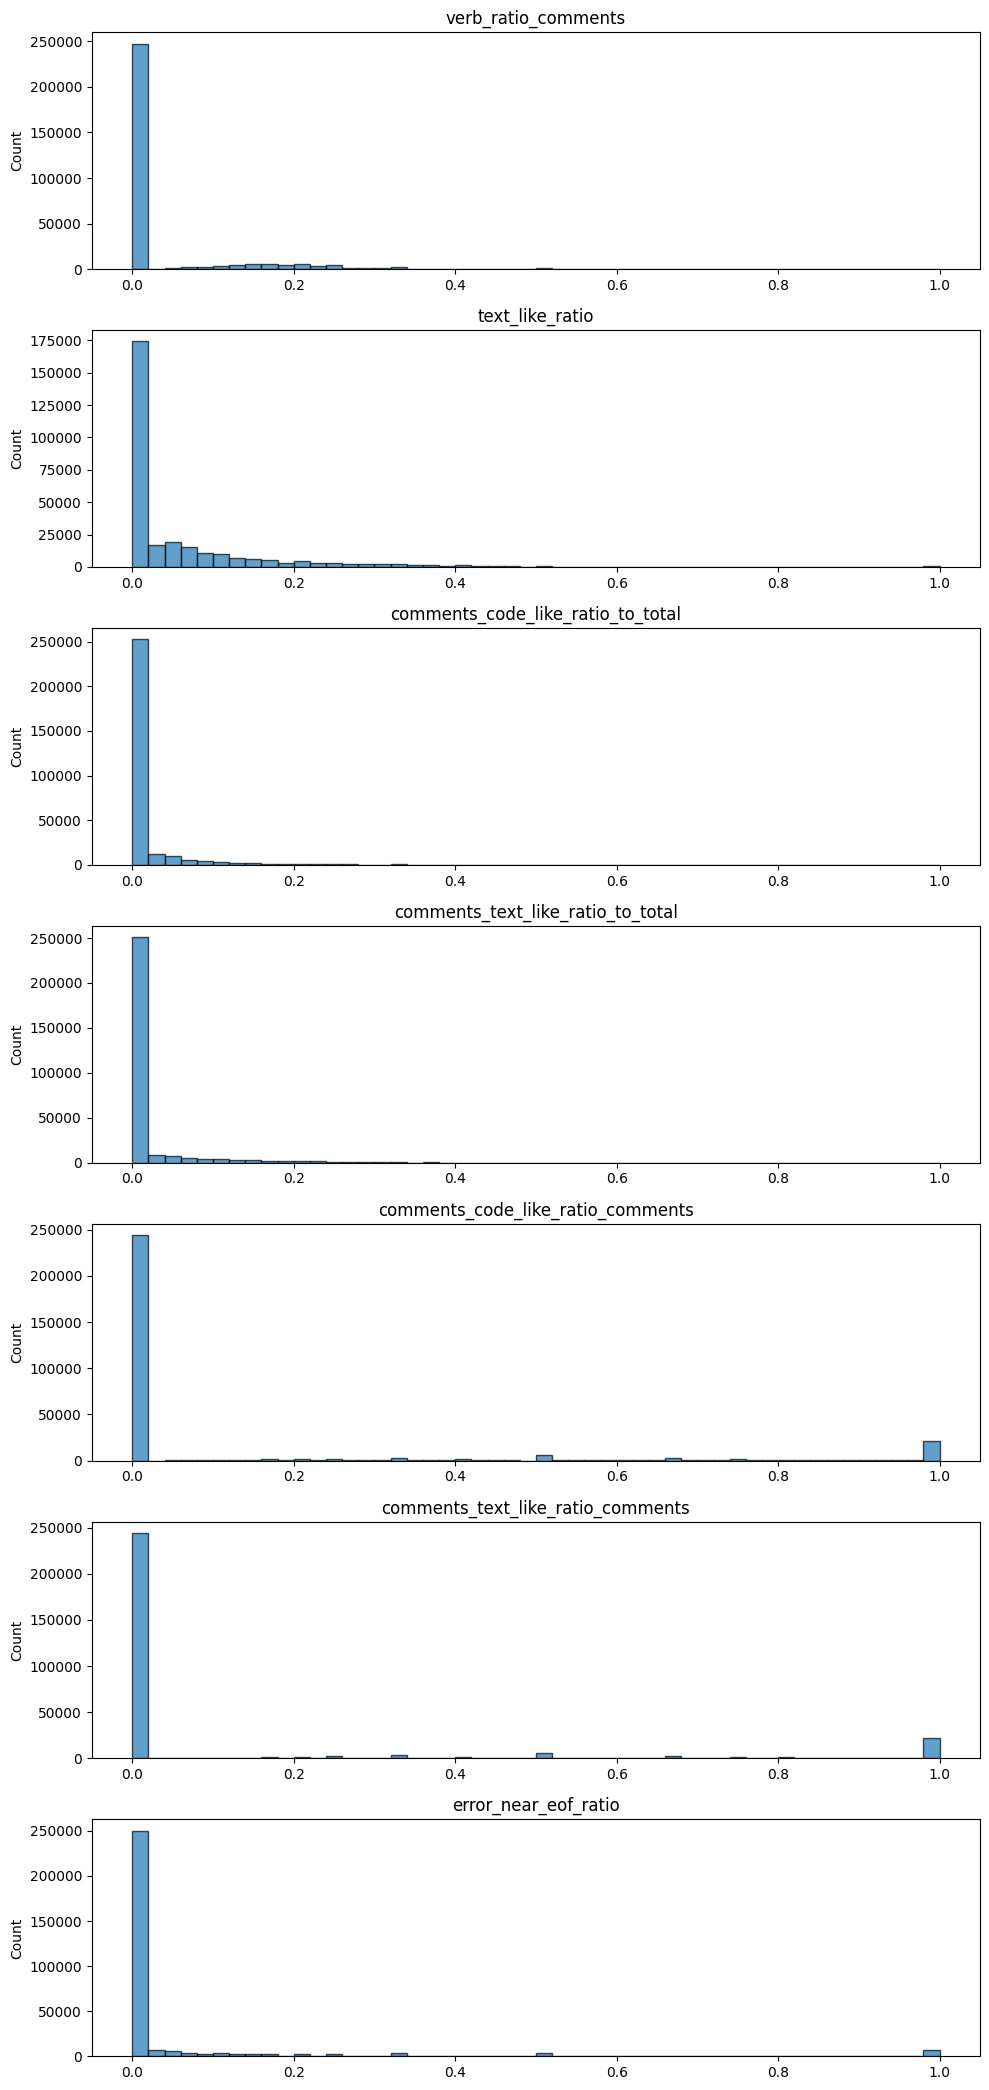

In [3]:
# Distribution histograms for each numeric feature
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 3 * len(numeric_cols)))
for ax, col in zip(axes, numeric_cols):
    ax.hist(df_feats[col].dropna(), bins=50, edgecolor="black", alpha=0.7)
    ax.set_title(col)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

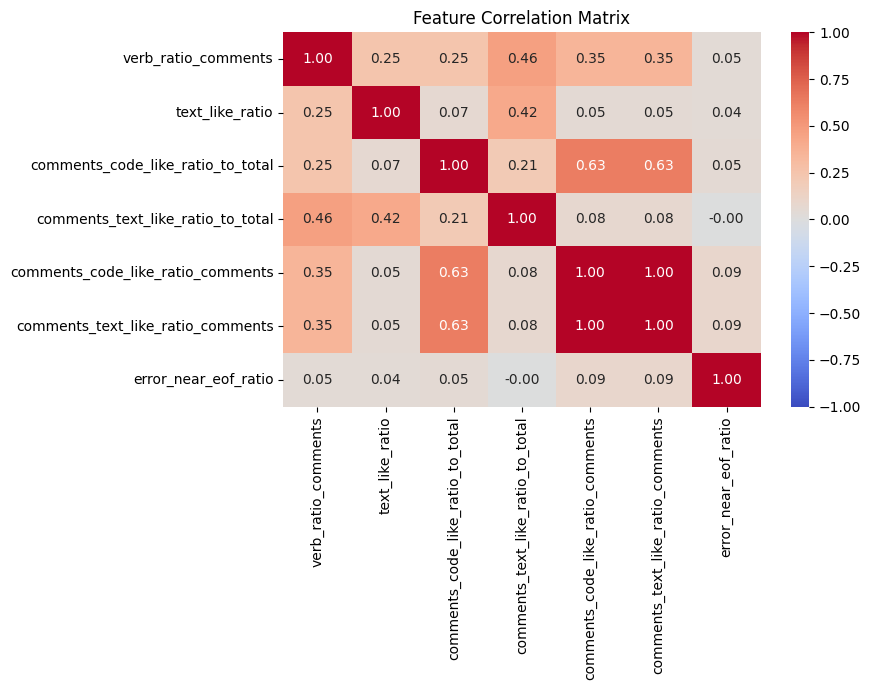

In [4]:
# Correlation heatmap
corr = df_feats[numeric_cols].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

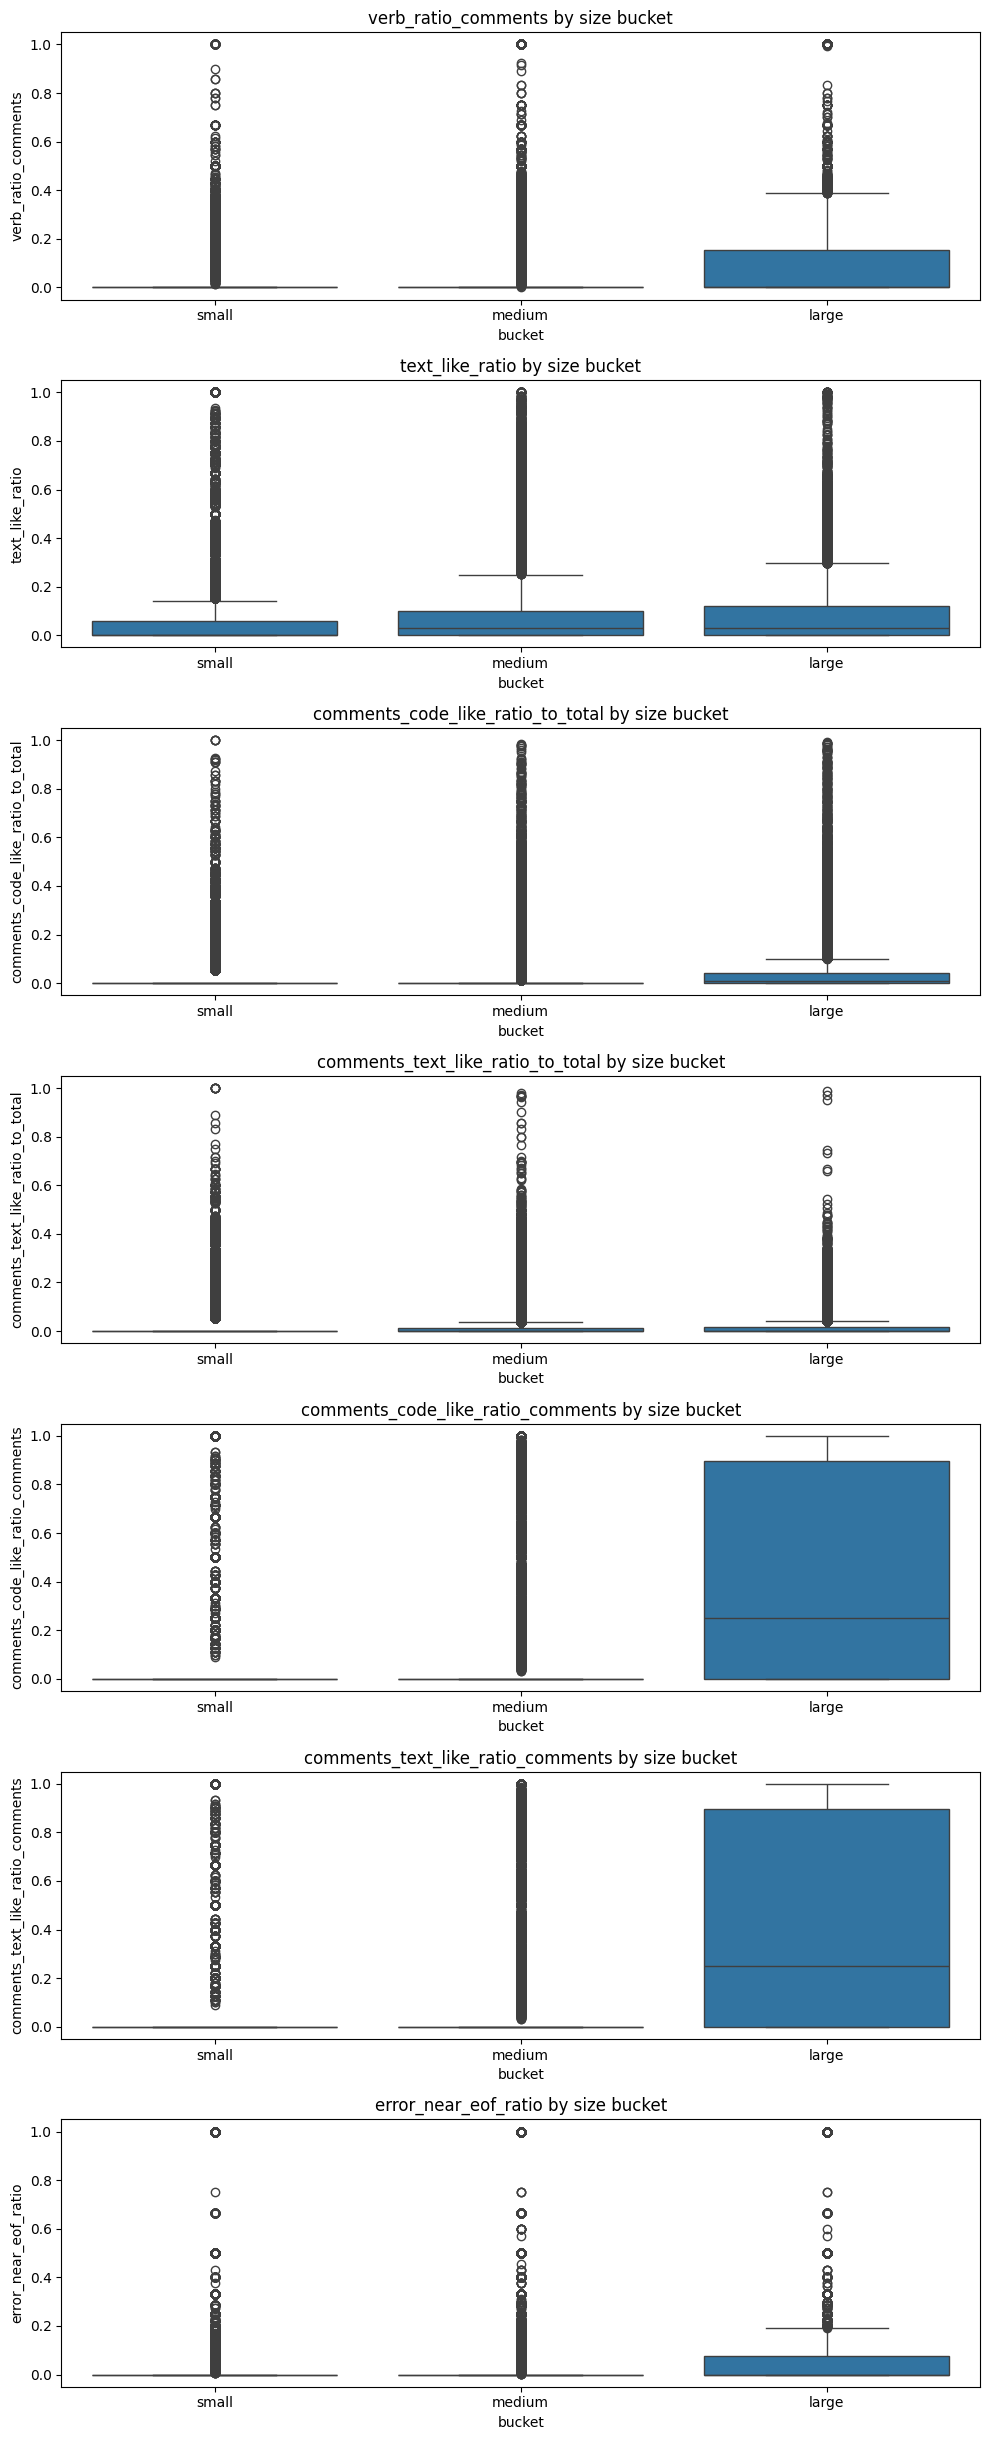


Bucket distribution:
bucket
small     135173
medium    130594
large      34233
Name: count, dtype: int64


In [5]:
# Box-plots per bucket (size category)
if "bucket" in df_feats.columns:
    fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 3.5 * len(numeric_cols)))
    for ax, col in zip(axes, numeric_cols):
        sns.boxplot(data=df_feats, x="bucket", y=col, ax=ax,
                    order=["small", "medium", "large"])
        ax.set_title(f"{col} by size bucket")
    plt.tight_layout()
    plt.show()

# Bucket value counts
print("\nBucket distribution:")
print(df_feats["bucket"].value_counts())

### Feature Analysis by Label

Compare feature distributions between human-written (label=0) and AI-generated (label=1) code snippets.

In [6]:
# Load labels from train parquet and align with features (first 300k rows)
df_train_labels = pd.read_parquet("data/semeval/train.parquet", columns=["label"])
df_feats["label"] = df_train_labels["label"].head(len(df_feats)).values

label_map = {0: "Human", 1: "AI-generated"}
df_feats["label_name"] = df_feats["label"].map(label_map)

print(f"Label distribution:\n{df_feats['label'].value_counts()}")
print(f"\nLabel balance: {df_feats['label'].mean():.2%} AI-generated")

Label distribution:
label
1    156939
0    143061
Name: count, dtype: int64

Label balance: 52.31% AI-generated


In [7]:
# Per-label descriptive statistics
for label, name in label_map.items():
    print(f"\n{'='*60}")
    print(f"  {name} (label={label})  —  n={len(df_feats[df_feats['label']==label])}")
    print(f"{'='*60}")
    sub = df_feats[df_feats["label"] == label][numeric_cols]
    stats = sub.describe().T
    stats["median"] = sub.median()
    stats["zero_pct"] = (sub == 0).mean() * 100
    print(stats[["mean", "std", "median", "min", "max", "zero_pct"]].round(4).to_string())


  Human (label=0)  —  n=143061
                                     mean     std  median  min     max  zero_pct
verb_ratio_comments                0.0060  0.0457     0.0  0.0  1.0000   97.1725
text_like_ratio                    0.0169  0.0396     0.0  0.0  1.0000   76.3751
comments_code_like_ratio_to_total  0.0047  0.0298     0.0  0.0  0.8435   94.3087
comments_text_like_ratio_to_total  0.0005  0.0059     0.0  0.0  0.7458   97.7555
comments_code_like_ratio_comments  0.0514  0.2136     0.0  0.0  1.0000   94.3087
comments_text_like_ratio_comments  0.0514  0.2136     0.0  0.0  1.0000   94.3087
error_near_eof_ratio               0.0037  0.0281     0.0  0.0  1.0000   97.2676

  AI-generated (label=1)  —  n=156939
                                     mean     std  median  min  max  zero_pct
verb_ratio_comments                0.0637  0.1159    0.00  0.0  1.0   69.0561
text_like_ratio                    0.1089  0.1564    0.05  0.0  1.0   36.4862
comments_code_like_ratio_to_total  0.0276  0.07

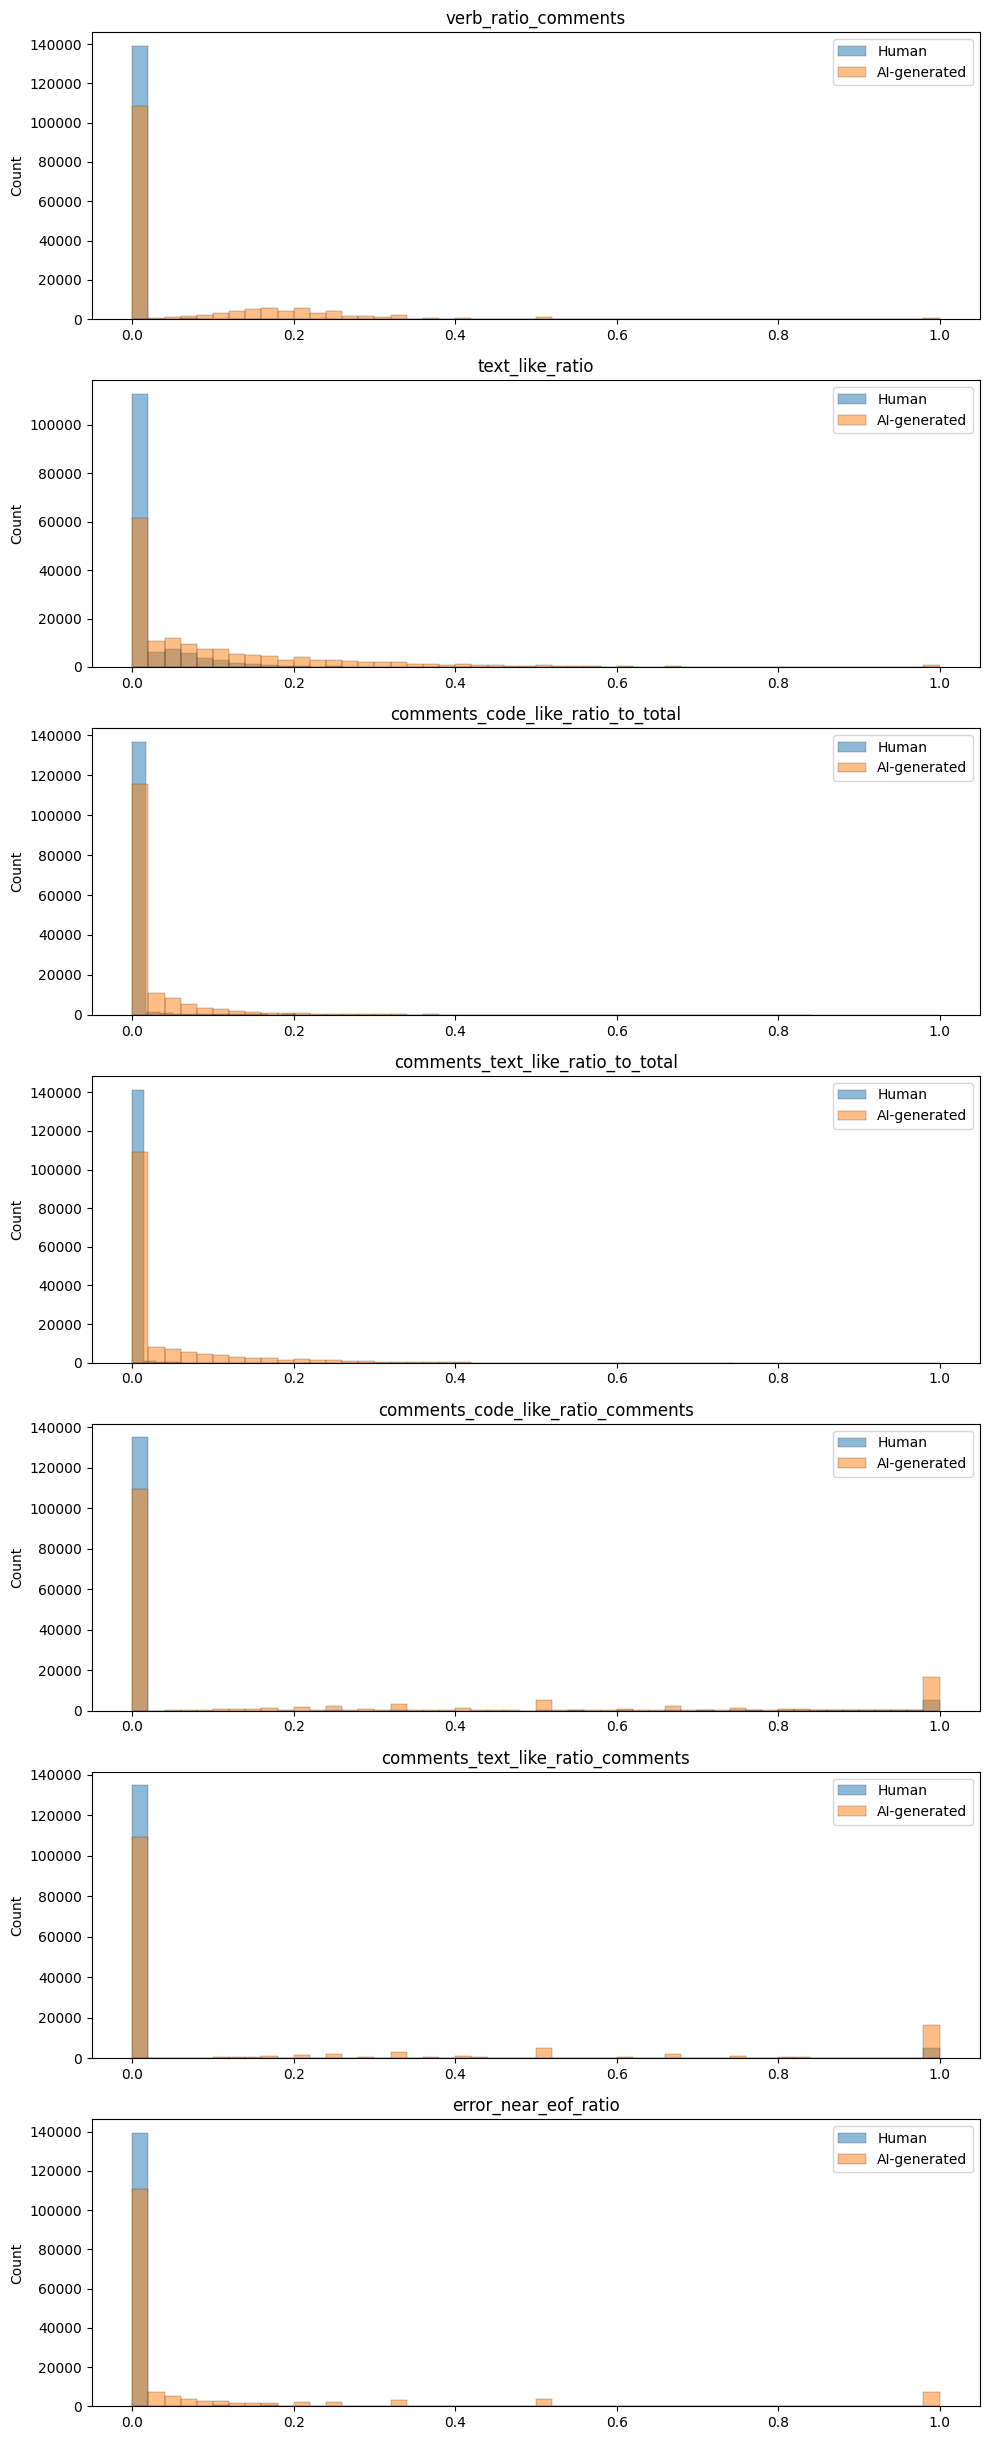

In [8]:
# Side-by-side histograms per feature, colored by label
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 3.5 * len(numeric_cols)))
for ax, col in zip(axes, numeric_cols):
    for label, name in label_map.items():
        sub = df_feats[df_feats["label"] == label][col].dropna()
        ax.hist(sub, bins=50, alpha=0.5, label=name, edgecolor="black", linewidth=0.3)
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.legend()
plt.tight_layout()
plt.show()

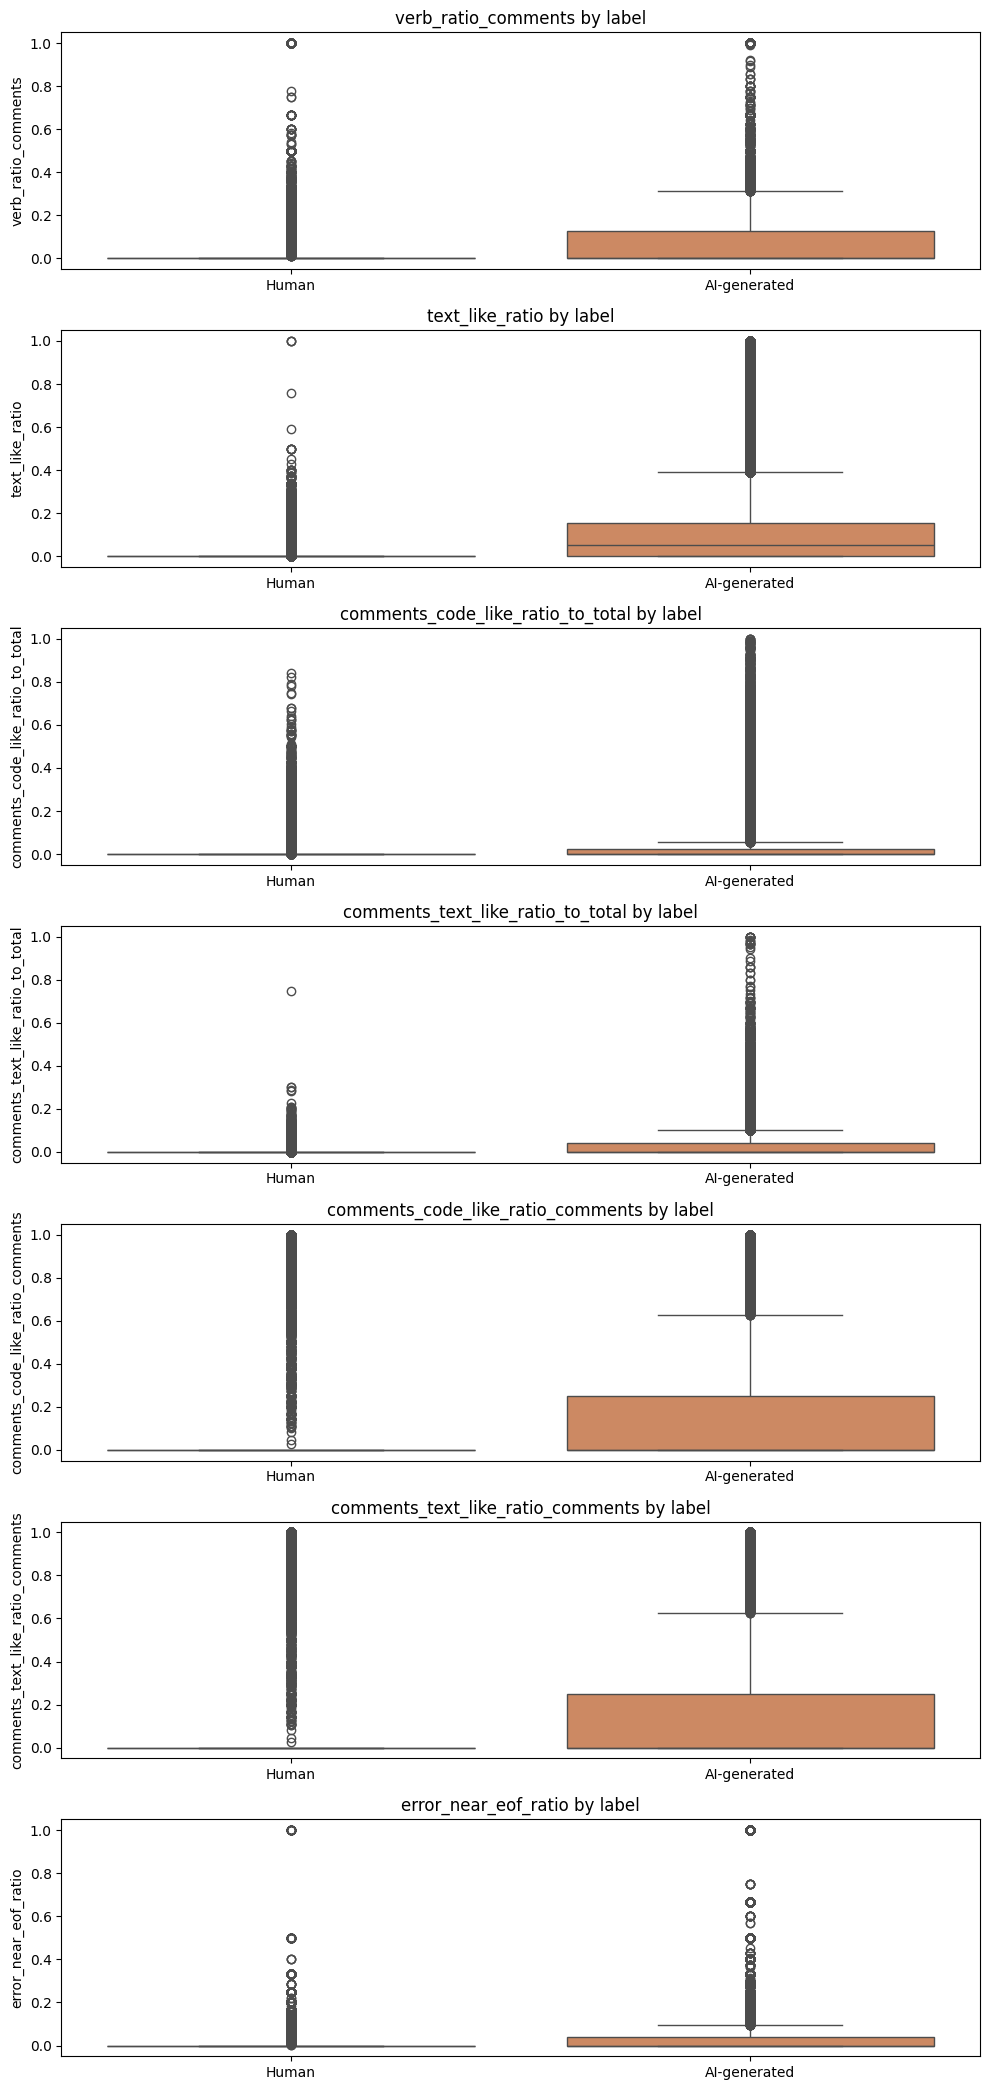

In [9]:
# Box-plots per feature by label
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 3 * len(numeric_cols)))
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(data=df_feats, x="label_name", y=col, ax=ax,
                order=["Human", "AI-generated"], hue="label_name",
                palette={"Human": "#4c72b0", "AI-generated": "#dd8452"}, legend=False)
    ax.set_title(f"{col} by label")
    ax.set_xlabel("")
plt.tight_layout()
plt.show()

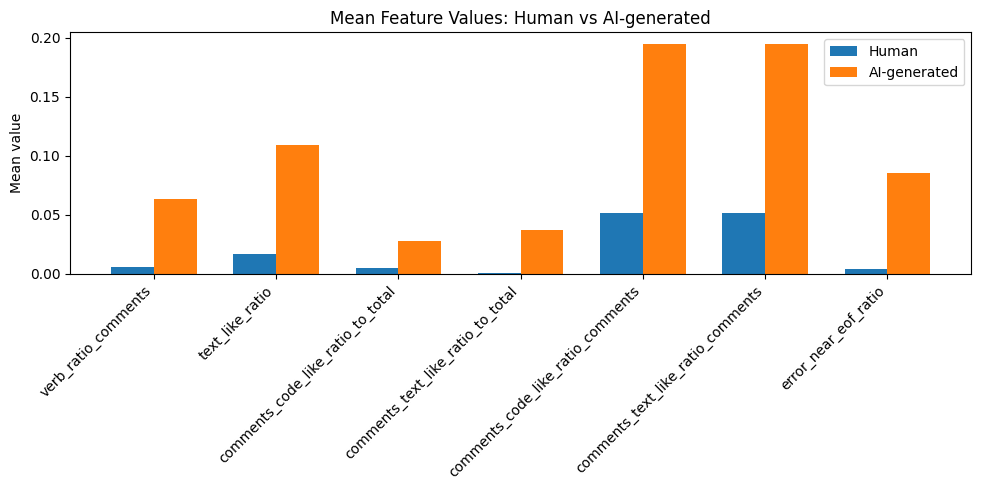


Mean difference (AI - Human):
verb_ratio_comments                  0.0577
text_like_ratio                      0.0920
comments_code_like_ratio_to_total    0.0229
comments_text_like_ratio_to_total    0.0363
comments_code_like_ratio_comments    0.1436
comments_text_like_ratio_comments    0.1436
error_near_eof_ratio                 0.0817


In [10]:
# Mean feature values comparison: Human vs AI
mean_by_label = df_feats.groupby("label_name")[numeric_cols].mean()
diff = mean_by_label.loc["AI-generated"] - mean_by_label.loc["Human"]

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(numeric_cols))
ax.bar(x, mean_by_label.loc["Human"], width=0.35, label="Human", align="center")
ax.bar([i + 0.35 for i in x], mean_by_label.loc["AI-generated"], width=0.35, label="AI-generated", align="center")
ax.set_xticks([i + 0.175 for i in x])
ax.set_xticklabels(numeric_cols, rotation=45, ha="right")
ax.set_ylabel("Mean value")
ax.set_title("Mean Feature Values: Human vs AI-generated")
ax.legend()
plt.tight_layout()
plt.show()

print("\nMean difference (AI - Human):")
print(diff.round(4).to_string())